Задачи

* Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.
* Взять данные для предсказания заболеваний сердца тут (целевой признак для предсказания --- target). Демо блокнот с анализом этих данных можно найти тут.
* Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (Data Cleaning).
* Выполнить разведочный анализ (EDA), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
* При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (Feature Engineering).
* Используя подбор гиперпараметров, кросс-валидацию и при необходимости масштабирование данных, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.
* Повторить предыдущий пункт для библиотечных реализаций (например, из sklearn) всех пройденных методов классификации (logistic regression, svm, knn, naive bayes, decision tree).
* Сравнить все обученные модели, построить их confusion matrices. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.
* (+2 балла) Реализовать еще одиниз методов классификации и добавить его в сравнение.
* (+3 балла) Найти данные, на которых интересно будет решать задачу классификации. Повторить все пункты задания на новых данных.

In [17]:
%precision 4
import warnings
warnings.filterwarnings('ignore')

Реализация метода KNN

In [18]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array

import numpy as np
np.set_printoptions(precision=4)

class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, num_neighbors=3):
        self._num_neighbors = num_neighbors

    def fit(self, X_train, y_train):
        X_train, y_train = check_X_y(X_train, y_train)
        self._X_train = X_train
        self._y_train = y_train
        return self

    def predict(self, X_test):
        X_test = check_array(X_test)
        predictions = []
        for test_row in X_test:
            neighbors_indexes = self._get_neighbors_indexes(test_row)
            label = self._most_popular_label(neighbors_indexes)
            predictions.append(label)
        return predictions

    def _get_neighbors_indexes(self, test_row):
        distances = list()
        for i, train_row in enumerate(self._X_train):
            dist = self._euclidean_distance(test_row, train_row)
            distances.append((i, dist))
        distances.sort(key=lambda tupl: tupl[1])
        neighbors_indexes = list()
        for i in range(self._num_neighbors):
            neighbors_indexes.append(distances[i][0])
        return neighbors_indexes

    def _most_popular_label(self, neighbors_indexes):
        labels = []
        for i in neighbors_indexes:
            labels.append(self._y_train[i])
        label = max(set(labels), key=labels.count)
        return label

    def _euclidean_distance(self, row1, row2):
        distance = 0.0
        for i in range(len(row1) - 1):
            distance += (row1[i] - row2[i]) ** 2
        return np.sqrt(distance)

    def get_params(self, deep=True):
        return {"num_neighbors": self._num_neighbors}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

Реализация метода SVM

In [19]:
class SVMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, alpha_value=1E-1, lamda_value=1E-1):
        self._alpha_value = alpha_value
        self._lamda_value = lamda_value

    def fit(self, X_train, y_train):
        X_train, y_train = check_X_y(X_train, y_train)
        self._X_train = X_train
        self._y_train = y_train
        self._update_weights()
        return self

    def _update_weights(self):
        y_train_labels = np.where(self._y_train <= 0, -1, 1)
        self.w = np.zeros(self._X_train.shape[1])
        self.b = 0
        for i, train_row in enumerate(self._X_train):
            dw = 0
            db = 0
            if y_train_labels[i] * (np.dot(train_row, self.w) - self.b) >= 1:
                dw = 2 * self._lamda_value * self.w
                db = 0
            else:
                dw = 2 * self._lamda_value * self.w - np.dot(train_row, y_train_labels[i])
                db = y_train_labels[i]
            self.w = self.w - self._alpha_value * dw
            self.b = self.b - self._alpha_value * db

    def predict(self, X_test):
        X_test = check_array(X_test)
        labels = np.sign(np.dot(X_test, self.w) - self.b)
        predictions = np.where(labels <= -1, 0, 1)
        return predictions

    def get_params(self, deep=True):
        return {"alpha_value": self._alpha_value,
                "lamda_value": self._lamda_value}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

Описание признаков

Признаки:
- age - возраст в годах,
- sex - пол (1 муж, 0 жен),
- cp - тип боли в груди,
- trestbps - артериальное давление в состоянии покоя при поступлении в больницу (в мм рт. ст.),
- chol - холестерин в крови (в мг./дл.),
- fbs - сахар в крови натощак > 120 мг/дл (1 да, 0 нет),
- restecg - результаты электрокардиографии в состоянии покоя,
- thalach - максимальная частота сердечных сокращений,
- exang - стенокардия из-за физической нагрузки (1 да, 0 нет),
- oldpeak - депрессия ST, вызванная физической нагрузкой по сравнению с покоем,
- slope - наклон сегмента ST пиковой физической нагрузки,
- ca - количество крупных сосудов (0 - 3), окрашенных при флоуроскопии,
- thal - (3 = норма; 6 = фиксированный дефект; 7 = обратимый дефект).

Целевой признак: target - есть болезнь или нет (1 да, 0 нет).

In [20]:
import pandas as pd

df = pd.read_csv("D:\INSTALL\SPbU\ML\heart.csv")
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


Есть категориальные признаки, их придётся кодировать.

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


Пропущенных значений нет, поэтому дополнительно их чистить или дополнять не требуется.

In [22]:
df.target.value_counts()

1    526
0    499
Name: target, dtype: int64

Пациентов с заболеванием сердца чуть больше.

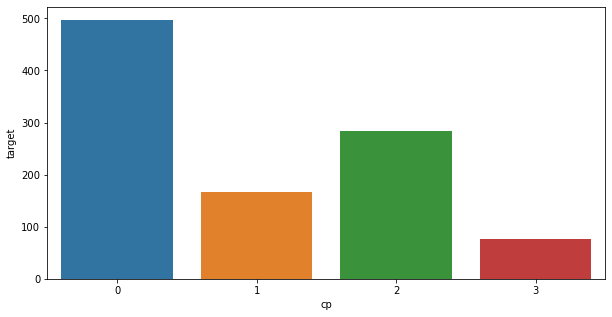

In [23]:
desease_count = df['target'].groupby(df['cp']).count()
f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.barplot(x=desease_count.index, y=desease_count)

Самый популярный тип боли - 0.

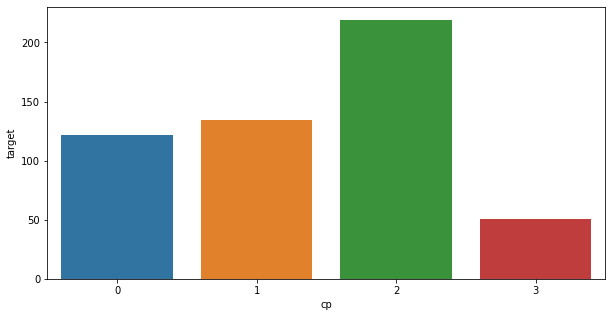

In [24]:
desease_sum = df['target'].groupby(df['cp']).sum()
f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.barplot(x=desease_sum.index, y=desease_sum)

При это с болью нулевого типо заболевших не так много. Зато у большинства пациентов с остальными типами боли заболевания серца присутствуют.

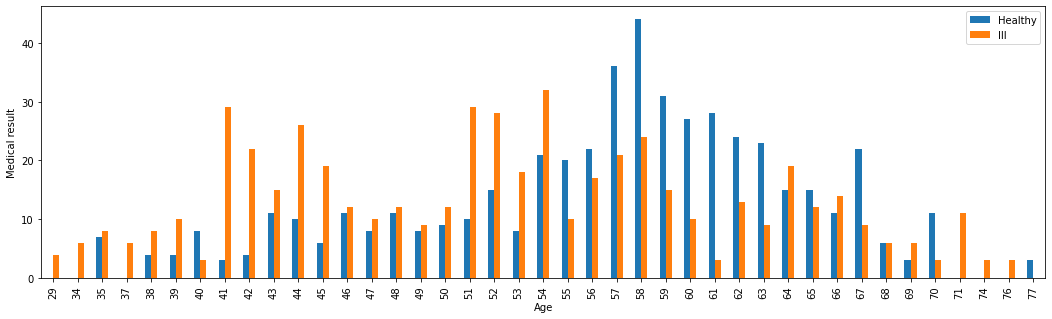

In [25]:
pd.crosstab(df.age, df.target).plot(kind="bar", figsize=(18, 5))
plt.xlabel('Age')
plt.ylabel('Medical result')
plt.legend(["Healthy", "Ill"])
plt.show()

Чаще всего заболевания сердца фиксируются впервые в возрасте от 41 до 54 лет.

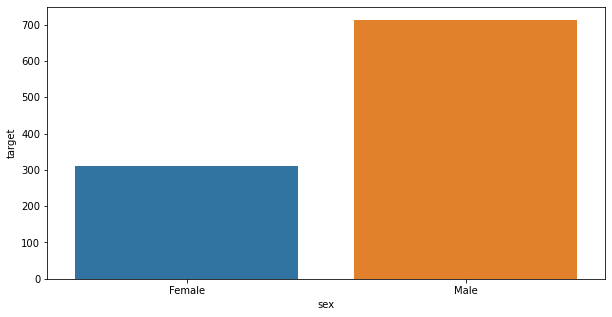

In [26]:
desease_count = df['target'].groupby(df['sex']).count()
f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.barplot(x=desease_count.index, y=desease_count)
_ = ax.set_xticklabels(["Female", "Male"])

У мужчин заболевания сердца встречаются вдвое чаще.

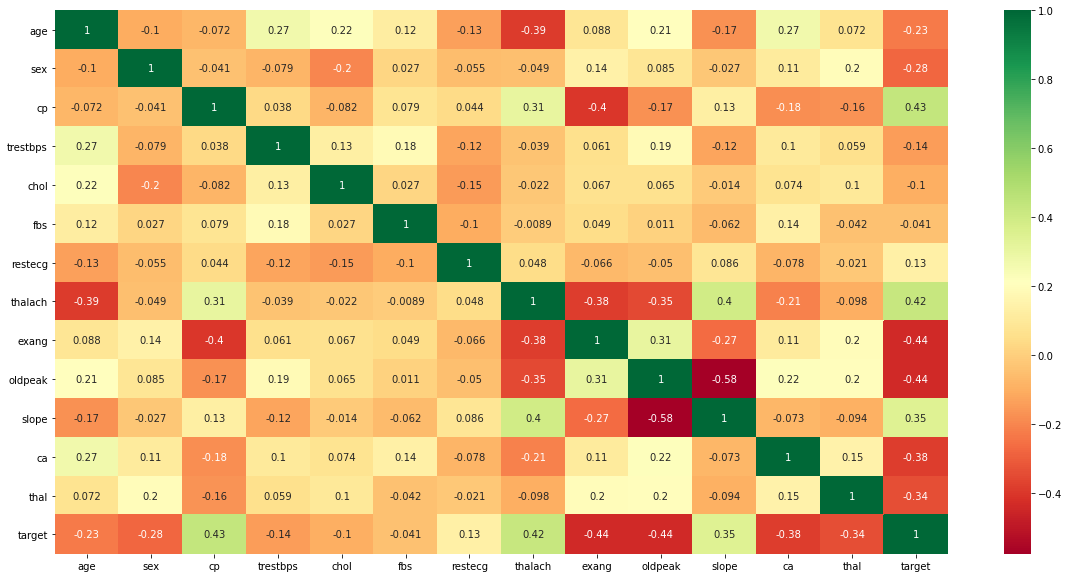

In [27]:
plt.figure(figsize = (20,10))
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')

Избавимся от слабых признаков, таких как restecg, chol, fbs, trestbps.

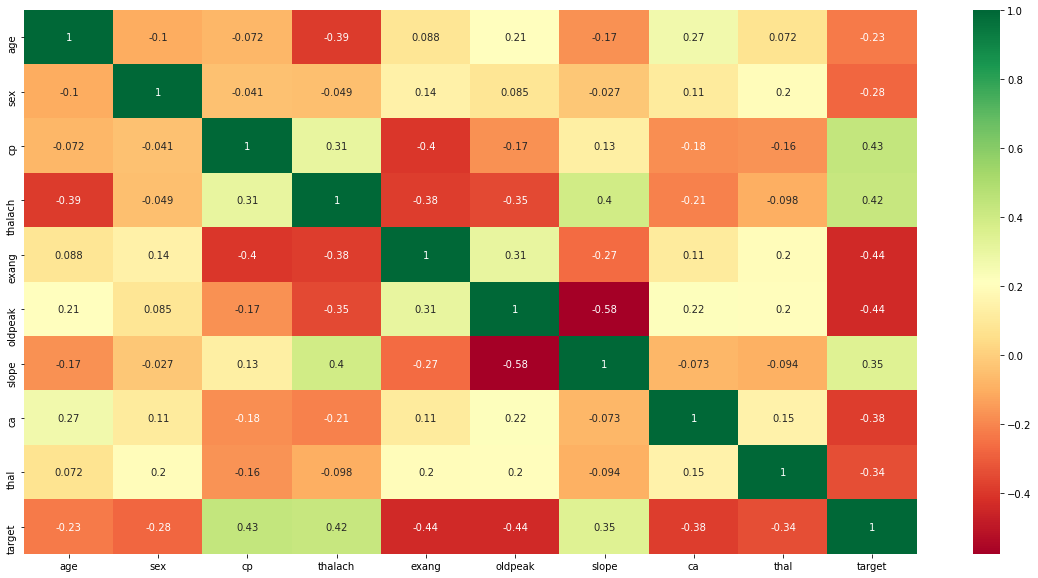

In [28]:
df.drop(columns=['restecg', 'chol', 'fbs', 'trestbps'], inplace=True)
plt.figure(figsize = (20,10))
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')

Такая картина лучше подходит для работы.

В датасете есть категориальные признаки cp, slope и thal. Закодируем их.

In [29]:
cp_dum = pd.get_dummies(df['cp'], prefix = "cp")
thal_dum = pd.get_dummies(df['thal'], prefix = "thal")
slope_dum = pd.get_dummies(df['slope'], prefix = "slope")

frames = [df, cp_dum, thal_dum, slope_dum]
df = pd.concat(frames, axis = 1).drop(columns = ['cp', 'thal', 'slope'])
df

,age,sex,thalach,exang,oldpeak,ca,target,cp_0,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,52,1,168,0,1.0,2,0,1,0,0,0,0,0,0,1,0,0,1
1,53,1,155,1,3.1,0,0,1,0,0,0,0,0,0,1,1,0,0
2,70,1,125,1,2.6,0,0,1,0,0,0,0,0,0,1,1,0,0
3,61,1,161,0,0.0,1,0,1,0,0,0,0,0,0,1,0,0,1
4,62,0,106,0,1.9,3,0,1,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,164,1,0.0,0,1,0,1,0,0,0,0,1,0,0,0,1
1021,60,1,141,1,2.8,1,0,1,0,0,0,0,0,0,1,0,1,0
1022,47,1,118,1,1.0,1,0,1,0,0,0,0,0,1,0,0,1,0
1023,50,0,159,0,0.0,0,1,1,0,0,0,0,0,1,0,0,0,1


Разделим выборку на тренировочную и тестовую

In [30]:
from sklearn.model_selection import train_test_split

x = df.drop(['target'], axis=1)
y = df['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=19)

Масштабируем признаки

In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns=x.columns)
x_train_scaled

,age,sex,thalach,exang,oldpeak,ca,cp_0,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,0.851853,-1.436141,-2.256844,-0.694004,0.080802,0.210744,-0.935049,-0.446431,1.575511,-0.295234,-0.076584,-0.248836,-1.094860,1.248880,-0.286389,1.082075,-0.929586
1,-1.245832,0.696311,0.541073,-0.694004,0.659063,0.210744,-0.935049,-0.446431,1.575511,-0.295234,-0.076584,-0.248836,0.913359,-0.800717,-0.286389,-0.924150,1.075748
2,-0.362597,0.696311,0.196714,1.440914,-0.910502,0.210744,-0.935049,-0.446431,1.575511,-0.295234,-0.076584,-0.248836,-1.094860,1.248880,-0.286389,-0.924150,1.075748
3,0.741448,-1.436141,0.842387,-0.694004,-0.910502,-0.740377,1.069462,-0.446431,-0.634715,-0.295234,-0.076584,-0.248836,0.913359,-0.800717,-0.286389,-0.924150,1.075748
4,-1.356237,0.696311,1.918509,-0.694004,-0.249632,-0.740377,-0.935049,-0.446431,1.575511,-0.295234,-0.076584,-0.248836,-1.094860,1.248880,3.491749,-0.924150,-0.929586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,0.410235,0.696311,0.670207,-0.694004,-0.910502,-0.740377,-0.935049,-0.446431,1.575511,-0.295234,-0.076584,-0.248836,0.913359,-0.800717,-0.286389,-0.924150,1.075748
682,-1.245832,0.696311,0.541073,-0.694004,0.659063,0.210744,-0.935049,-0.446431,1.575511,-0.295234,-0.076584,-0.248836,0.913359,-0.800717,-0.286389,-0.924150,1.075748
683,0.299830,0.696311,-0.362870,-0.694004,-0.662676,-0.740377,-0.935049,2.239987,-0.634715,-0.295234,-0.076584,-0.248836,-1.094860,1.248880,-0.286389,-0.924150,1.075748
684,1.293470,0.696311,-0.492004,-0.694004,0.989498,-0.740377,1.069462,-0.446431,-0.634715,-0.295234,-0.076584,4.018706,-1.094860,-0.800717,-0.286389,-0.924150,1.075748


In [32]:
x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns=x.columns)
x_test_scaled

,age,sex,thalach,exang,oldpeak,ca,cp_0,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,0.631044,-1.436141,0.928477,-0.694004,-0.167024,-0.740377,-0.935049,-0.446431,-0.634715,3.387141,-0.076584,-0.248836,0.913359,-0.800717,-0.286389,-0.924150,1.075748
1,0.962257,-1.436141,0.971522,-0.694004,-0.910502,-0.740377,-0.935049,-0.446431,1.575511,-0.295234,-0.076584,-0.248836,0.913359,-0.800717,-0.286389,-0.924150,1.075748
2,0.299830,0.696311,-0.362870,-0.694004,-0.662676,-0.740377,-0.935049,2.239987,-0.634715,-0.295234,-0.076584,-0.248836,-1.094860,1.248880,-0.286389,-0.924150,1.075748
3,-1.797855,0.696311,1.014567,-0.694004,-0.910502,3.064106,-0.935049,-0.446431,1.575511,-0.295234,-0.076584,-0.248836,0.913359,-0.800717,-0.286389,-0.924150,1.075748
4,1.624684,-1.436141,0.067579,-0.694004,0.576455,1.161865,-0.935049,-0.446431,-0.634715,3.387141,-0.076584,-0.248836,0.913359,-0.800717,-0.286389,-0.924150,1.075748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,0.410235,0.696311,-0.793318,1.440914,0.906889,2.112985,1.069462,-0.446431,-0.634715,-0.295234,-0.076584,-0.248836,-1.094860,1.248880,-0.286389,1.082075,-0.929586
335,-0.031383,0.696311,-1.568126,-0.694004,0.246020,0.210744,1.069462,-0.446431,-0.634715,-0.295234,-0.076584,-0.248836,-1.094860,1.248880,-0.286389,1.082075,-0.929586
336,-2.129068,0.696311,-0.836363,1.440914,0.411237,-0.740377,1.069462,-0.446431,-0.634715,-0.295234,-0.076584,-0.248836,-1.094860,1.248880,-0.286389,1.082075,-0.929586
337,-0.252192,0.696311,0.282804,1.440914,-0.084415,-0.740377,1.069462,-0.446431,-0.634715,-0.295234,13.057565,-0.248836,-1.094860,-0.800717,-0.286389,1.082075,-0.929586


Посмотрим на оптимальность признаков.

In [33]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import RidgeClassifierCV

rfecv = RFECV(estimator=RidgeClassifierCV())

rfecv.fit(x_train_scaled, y_train)

selected_features = list(x_train_scaled.columns[rfecv.support_])
print("Optimal features: ", rfecv.n_features_)
print("Selected features: ", selected_features)

Optimal features:  13
Selected features:  ['age', 'sex', 'thalach', 'exang', 'oldpeak', 'ca', 'cp_0', 'cp_2', 'cp_3', 'thal_1', 'thal_2', 'thal_3', 'slope_1']


Возьмём только оптимальные признаки.

In [34]:
x_train_scaled = x_train_scaled[selected_features]
x_train_scaled

,age,sex,thalach,exang,oldpeak,ca,cp_0,cp_2,cp_3,thal_1,thal_2,thal_3,slope_1
0,0.851853,-1.436141,-2.256844,-0.694004,0.080802,0.210744,-0.935049,1.575511,-0.295234,-0.248836,-1.094860,1.248880,1.082075
1,-1.245832,0.696311,0.541073,-0.694004,0.659063,0.210744,-0.935049,1.575511,-0.295234,-0.248836,0.913359,-0.800717,-0.924150
2,-0.362597,0.696311,0.196714,1.440914,-0.910502,0.210744,-0.935049,1.575511,-0.295234,-0.248836,-1.094860,1.248880,-0.924150
3,0.741448,-1.436141,0.842387,-0.694004,-0.910502,-0.740377,1.069462,-0.634715,-0.295234,-0.248836,0.913359,-0.800717,-0.924150
4,-1.356237,0.696311,1.918509,-0.694004,-0.249632,-0.740377,-0.935049,1.575511,-0.295234,-0.248836,-1.094860,1.248880,-0.924150
...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,0.410235,0.696311,0.670207,-0.694004,-0.910502,-0.740377,-0.935049,1.575511,-0.295234,-0.248836,0.913359,-0.800717,-0.924150
682,-1.245832,0.696311,0.541073,-0.694004,0.659063,0.210744,-0.935049,1.575511,-0.295234,-0.248836,0.913359,-0.800717,-0.924150
683,0.299830,0.696311,-0.362870,-0.694004,-0.662676,-0.740377,-0.935049,-0.634715,-0.295234,-0.248836,-1.094860,1.248880,-0.924150
684,1.293470,0.696311,-0.492004,-0.694004,0.989498,-0.740377,1.069462,-0.634715,-0.295234,4.018706,-1.094860,-0.800717,-0.924150


In [35]:
x_test_scaled = x_test_scaled[selected_features]
x_test_scaled

,age,sex,thalach,exang,oldpeak,ca,cp_0,cp_2,cp_3,thal_1,thal_2,thal_3,slope_1
0,0.631044,-1.436141,0.928477,-0.694004,-0.167024,-0.740377,-0.935049,-0.634715,3.387141,-0.248836,0.913359,-0.800717,-0.924150
1,0.962257,-1.436141,0.971522,-0.694004,-0.910502,-0.740377,-0.935049,1.575511,-0.295234,-0.248836,0.913359,-0.800717,-0.924150
2,0.299830,0.696311,-0.362870,-0.694004,-0.662676,-0.740377,-0.935049,-0.634715,-0.295234,-0.248836,-1.094860,1.248880,-0.924150
3,-1.797855,0.696311,1.014567,-0.694004,-0.910502,3.064106,-0.935049,1.575511,-0.295234,-0.248836,0.913359,-0.800717,-0.924150
4,1.624684,-1.436141,0.067579,-0.694004,0.576455,1.161865,-0.935049,-0.634715,3.387141,-0.248836,0.913359,-0.800717,-0.924150
...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,0.410235,0.696311,-0.793318,1.440914,0.906889,2.112985,1.069462,-0.634715,-0.295234,-0.248836,-1.094860,1.248880,1.082075
335,-0.031383,0.696311,-1.568126,-0.694004,0.246020,0.210744,1.069462,-0.634715,-0.295234,-0.248836,-1.094860,1.248880,1.082075
336,-2.129068,0.696311,-0.836363,1.440914,0.411237,-0.740377,1.069462,-0.634715,-0.295234,-0.248836,-1.094860,1.248880,1.082075
337,-0.252192,0.696311,0.282804,1.440914,-0.084415,-0.740377,1.069462,-0.634715,-0.295234,-0.248836,-1.094860,-0.800717,1.082075


Произведём подбор оптимальных гиперпараметров и кросс-валидацию

Для реализации KNNClassifier:

In [36]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

cv = StratifiedKFold(5, shuffle=True, random_state=19)

param_grid = [{"num_neighbors": [3, 5, 7, 9, 11, 13, 15]}]

searcher = GridSearchCV(KNNClassifier(), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train_scaled, y_train)

optimal_num_neighbors = searcher.best_params_["num_neighbors"]
print("Optimal num_neighbors =", optimal_num_neighbors)
print("Optimal score =", searcher.best_score_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] num_neighbors=3 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... num_neighbors=3, score=0.913, total=   1.5s
[CV] num_neighbors=3 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] ..................... num_neighbors=3, score=0.905, total=   1.4s
[CV] num_neighbors=3 .................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s


[CV] ..................... num_neighbors=3, score=0.927, total=   1.4s
[CV] num_neighbors=3 .................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.2s remaining:    0.0s


[CV] ..................... num_neighbors=3, score=0.912, total=   1.4s
[CV] num_neighbors=3 .................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.6s remaining:    0.0s


[CV] ..................... num_neighbors=3, score=0.839, total=   1.4s
[CV] num_neighbors=5 .................................................
[CV] ..................... num_neighbors=5, score=0.913, total=   1.4s
[CV] num_neighbors=5 .................................................
[CV] ..................... num_neighbors=5, score=0.905, total=   1.4s
[CV] num_neighbors=5 .................................................
[CV] ..................... num_neighbors=5, score=0.927, total=   1.4s
[CV] num_neighbors=5 .................................................
[CV] ..................... num_neighbors=5, score=0.912, total=   1.4s
[CV] num_neighbors=5 .................................................
[CV] ..................... num_neighbors=5, score=0.839, total=   1.4s
[CV] num_neighbors=7 .................................................
[CV] ..................... num_neighbors=7, score=0.913, total=   1.4s
[CV] num_neighbors=7 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   50.0s finished


Для SVMClassifier:

In [37]:
param_grid = [{"alpha_value": [1E-1, 1E-2, 1E-3],
               "lamda_value": [1E-1, 1E-2, 1E-3]}]

searcher = GridSearchCV(SVMClassifier(), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train_scaled, y_train)

optimal_alpha_value = searcher.best_params_["alpha_value"]
print("Optimal alpha_value =", optimal_alpha_value)
optimal_lamda_value = searcher.best_params_["lamda_value"]
print("Optimal lamda_value =", optimal_lamda_value)
print("Optimal score =", searcher.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] alpha_value=0.1, lamda_value=0.1 ................................
[CV] .... alpha_value=0.1, lamda_value=0.1, score=0.775, total=   0.0s
[CV] alpha_value=0.1, lamda_value=0.1 ................................
[CV] .... alpha_value=0.1, lamda_value=0.1, score=0.839, total=   0.0s
[CV] alpha_value=0.1, lamda_value=0.1 ................................
[CV] .... alpha_value=0.1, lamda_value=0.1, score=0.854, total=   0.0s
[CV] alpha_value=0.1, lamda_value=0.1 ................................
[CV] .... alpha_value=0.1, lamda_value=0.1, score=0.839, total=   0.0s
[CV] alpha_value=0.1, lamda_value=0.1 ................................
[CV] .... alpha_value=0.1, lamda_value=0.1, score=0.803, total=   0.0s
[CV] alpha_value=0.1, lamda_value=0.01 ...............................
[CV] ... alpha_value=0.1, lamda_value=0.01, score=0.775, total=   0.0s
[CV] alpha_value=0.1, lamda_value=0.01 ...............................
[CV] ... alpha_va

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s



[CV] alpha_value=0.1, lamda_value=0.001 ..............................
[CV] .. alpha_value=0.1, lamda_value=0.001, score=0.775, total=   0.0s
[CV] alpha_value=0.1, lamda_value=0.001 ..............................
[CV] .. alpha_value=0.1, lamda_value=0.001, score=0.839, total=   0.0s
[CV] alpha_value=0.1, lamda_value=0.001 ..............................
[CV] .. alpha_value=0.1, lamda_value=0.001, score=0.854, total=   0.0s
[CV] alpha_value=0.1, lamda_value=0.001 ..............................
[CV] .. alpha_value=0.1, lamda_value=0.001, score=0.839, total=   0.0s
[CV] alpha_value=0.1, lamda_value=0.001 ..............................
[CV] .. alpha_value=0.1, lamda_value=0.001, score=0.803, total=   0.0s
[CV] alpha_value=0.01, lamda_value=0.1 ...............................
[CV] ... alpha_value=0.01, lamda_value=0.1, score=0.775, total=   0.0s
[CV] alpha_value=0.01, lamda_value=0.1 ...............................
[CV] ... alpha_value=0.01, lamda_value=0.1, score=0.839, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.7s finished


Для библиотечной реализации LogisticRegression

In [38]:
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [1E-3, 1E-1, 1, 1E+1, 1E+3]}

searcher = GridSearchCV(LogisticRegression(random_state=19), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train_scaled, y_train)

optimal_logreg_c = searcher.best_params_["C"]
print("Optimal params =", searcher.best_params_)
print("Optimal score =", searcher.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] C=0.001 .........................................................
[CV] ............................. C=0.001, score=0.884, total=   0.1s
[CV] C=0.001 .........................................................
[CV] ............................. C=0.001, score=0.839, total=   0.0s
[CV] C=0.001 .........................................................
[CV] ............................. C=0.001, score=0.854, total=   0.0s
[CV] C=0.001 .........................................................
[CV] ............................. C=0.001, score=0.861, total=   0.0s
[CV] C=0.001 .........................................................
[CV] ............................. C=0.001, score=0.810, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.884, total=   0.0s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s



[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.847, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.869, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.854, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.774, total=   0.0s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.884, total=   0.0s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.832, total=   0.0s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.869, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.4s finished


Для библиотечной реализации SVM

In [39]:
from sklearn.svm import SVC

param_grid = {"kernel": ["linear", "rbf"],
              "C": [0.1, 0.25, 0.5, 0.75, 1, 2],
              "gamma": ["scale", "auto", 1E-3, 1E-1, 1, 1E+1, 1E+3]}

searcher = GridSearchCV(SVC(random_state=19), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train_scaled, y_train)

optimal_kernel = searcher.best_params_["kernel"]
optimal_svm_c = searcher.best_params_["C"]
optimal_gamma = searcher.best_params_["gamma"]
print("Optimal params =", searcher.best_params_)
print("Optimal score =", searcher.best_score_)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV] C=0.1, gamma=scale, kernel=linear ...............................
[CV] ... C=0.1, gamma=scale, kernel=linear, score=0.877, total=   0.0s
[CV] C=0.1, gamma=scale, kernel=linear ...............................
[CV] ... C=0.1, gamma=scale, kernel=linear, score=0.832, total=   0.0s
[CV] C=0.1, gamma=scale, kernel=linear ...............................
[CV] ... C=0.1, gamma=scale, kernel=linear, score=0.876, total=   0.0s
[CV] C=0.1, gamma=scale, kernel=linear ...............................
[CV] ... C=0.1, gamma=scale, kernel=linear, score=0.861, total=   0.0s
[CV] C=0.1, gamma=scale, kernel=linear ...............................
[CV] ... C=0.1, gamma=scale, kernel=linear, score=0.803, total=   0.0s
[CV] C=0.1, gamma=scale, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=scale, kernel=rbf, score=0.899, total=   0.0s
[CV] C=0.1, gamma=scale, kernel=rbf ..................................
[CV] ...... C=0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


[CV] .... C=0.1, gamma=auto, kernel=linear, score=0.832, total=   0.0s
[CV] C=0.1, gamma=auto, kernel=linear ................................
[CV] .... C=0.1, gamma=auto, kernel=linear, score=0.876, total=   0.0s
[CV] C=0.1, gamma=auto, kernel=linear ................................
[CV] .... C=0.1, gamma=auto, kernel=linear, score=0.861, total=   0.0s
[CV] C=0.1, gamma=auto, kernel=linear ................................
[CV] .... C=0.1, gamma=auto, kernel=linear, score=0.803, total=   0.0s
[CV] C=0.1, gamma=auto, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=auto, kernel=rbf, score=0.899, total=   0.0s
[CV] C=0.1, gamma=auto, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=auto, kernel=rbf, score=0.861, total=   0.0s
[CV] C=0.1, gamma=auto, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=auto, kernel=rbf, score=0.891, total=   0.0s
[CV] C=0.1, gamma=auto, kernel=rbf ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed:    7.1s finished


Для библиотечной реализации KNN

In [40]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = [{"n_neighbors": [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
               "weights": ['distance', 'uniform']}]

searcher = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train_scaled, y_train)

optimal_n_neighbors = searcher.best_params_["n_neighbors"]
optimal_weights = searcher.best_params_["weights"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] n_neighbors=1, weights=distance .................................
[CV] ..... n_neighbors=1, weights=distance, score=0.949, total=   0.0s
[CV] n_neighbors=1, weights=distance .................................
[CV] ..... n_neighbors=1, weights=distance, score=0.985, total=   0.0s
[CV] n_neighbors=1, weights=distance .................................
[CV] ..... n_neighbors=1, weights=distance, score=0.971, total=   0.0s
[CV] n_neighbors=1, weights=distance .................................
[CV] ..... n_neighbors=1, weights=distance, score=0.978, total=   0.0s
[CV] n_neighbors=1, weights=distance .................................
[CV] ..... n_neighbors=1, weights=distance, score=0.993, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ...... n_neighbors=1, weights=uniform, score=0.949, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ...... n_n

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


[CV] ...... n_neighbors=3, weights=uniform, score=0.920, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ...... n_neighbors=3, weights=uniform, score=0.934, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ...... n_neighbors=3, weights=uniform, score=0.920, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ...... n_neighbors=3, weights=uniform, score=0.905, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ...... n_neighbors=3, weights=uniform, score=0.847, total=   0.0s
[CV] n_neighbors=5, weights=distance .................................
[CV] ..... n_neighbors=5, weights=distance, score=0.949, total=   0.0s
[CV] n_neighbors=5, weights=distance .................................
[CV] ..... n_neighbors=5, weights=distance, score=0.993, total=   0.0s
[CV] n_neighbors=5, weights=distance .................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished


для библиотечной реализации Naive Bayes

In [41]:
from sklearn.naive_bayes import GaussianNB

param_grid = [{"priors": [[0.5, 0.5], [0.33, 0.67], [0.67, 0.33], [0.25, 0.75], [0.75, 0.25]],
               "var_smoothing": np.logspace(0, -10, num=100)}]

searcher = GridSearchCV(GaussianNB(), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train_scaled, y_train)

optimal_priors = searcher.best_params_["priors"]
optimal_var_smoothing = searcher.best_params_["var_smoothing"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV] priors=[0.5, 0.5], var_smoothing=1.0 ............................
[CV]  priors=[0.5, 0.5], var_smoothing=1.0, score=0.884, total=   0.0s
[CV] priors=[0.5, 0.5], var_smoothing=1.0 ............................
[CV]  priors=[0.5, 0.5], var_smoothing=1.0, score=0.839, total=   0.0s
[CV] priors=[0.5, 0.5], var_smoothing=1.0 ............................
[CV]  priors=[0.5, 0.5], var_smoothing=1.0, score=0.861, total=   0.0s
[CV] priors=[0.5, 0.5], var_smoothing=1.0 ............................
[CV]  priors=[0.5, 0.5], var_smoothing=1.0, score=0.861, total=   0.0s
[CV] priors=[0.5, 0.5], var_smoothing=1.0 ............................
[CV]  priors=[0.5, 0.5], var_smoothing=1.0, score=0.788, total=   0.0s
[CV] priors=[0.5, 0.5], var_smoothing=0.7924828983539173 .............
[CV]  priors=[0.5, 0.5], var_smoothing=0.7924828983539173, score=0.884, total=   0.0s
[CV] priors=[0.5, 0.5], var_smoothing=0.7924828983539173 ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


[CV]  priors=[0.5, 0.5], var_smoothing=0.3125715849688236, score=0.869, total=   0.0s
[CV] priors=[0.5, 0.5], var_smoothing=0.3125715849688236 .............
[CV]  priors=[0.5, 0.5], var_smoothing=0.3125715849688236, score=0.861, total=   0.0s
[CV] priors=[0.5, 0.5], var_smoothing=0.3125715849688236 .............
[CV]  priors=[0.5, 0.5], var_smoothing=0.3125715849688236, score=0.788, total=   0.0s
[CV] priors=[0.5, 0.5], var_smoothing=0.24770763559917108 ............
[CV]  priors=[0.5, 0.5], var_smoothing=0.24770763559917108, score=0.884, total=   0.0s
[CV] priors=[0.5, 0.5], var_smoothing=0.24770763559917108 ............
[CV]  priors=[0.5, 0.5], var_smoothing=0.24770763559917108, score=0.847, total=   0.0s
[CV] priors=[0.5, 0.5], var_smoothing=0.24770763559917108 ............
[CV]  priors=[0.5, 0.5], var_smoothing=0.24770763559917108, score=0.869, total=   0.0s
[CV] priors=[0.5, 0.5], var_smoothing=0.24770763559917108 ............
[CV]  priors=[0.5, 0.5], var_smoothing=0.24770763559917

[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:   16.4s finished


Для библиотечной реализации Decision Tree

In [42]:
from sklearn.tree import DecisionTreeClassifier

param_grid = [{"criterion": ["gini", "entropy", "log_loss"],
               "splitter": ["best", "random"],
               "max_depth": [10, 20, 30],
               "min_samples_split": [2, 5, 10],
               "min_samples_leaf": [2, 5, 10],
               "max_features": [2, 5, 10]}]

searcher = GridSearchCV(DecisionTreeClassifier(random_state=19), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train_scaled, y_train)

optimal_criterion = searcher.best_params_["criterion"]
optimal_splitter = searcher.best_params_["splitter"]
optimal_max_depth = searcher.best_params_["max_depth"]
optimal_min_samples_split = searcher.best_params_["min_samples_split"]
optimal_min_samples_leaf = searcher.best_params_["min_samples_leaf"]
optimal_max_features = searcher.best_params_["max_features"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
[CV] criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best 
[CV]  criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best, score=0.848, total=   0.0s
[CV] criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best 
[CV]  criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best, score=0.912, total=   0.0s
[CV] criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best 
[CV]  criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best, score=0.876, total=   0.0s
[CV] criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best 
[CV]  criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=b

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


[CV] criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=10, splitter=best 
[CV]  criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=10, splitter=best, score=0.839, total=   0.0s
[CV] criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=10, splitter=best 
[CV]  criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=10, splitter=best, score=0.839, total=   0.0s
[CV] criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=10, splitter=random 
[CV]  criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=10, splitter=random, score=0.783, total=   0.0s
[CV] criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=10, splitter=random 
[CV]  criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=10, splitter=random, score=0.861, total=   0.0s
[CV] criterion=g

[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:   14.2s finished


Протестируем обученные модели

In [51]:
scores = {}

Мой KNNClassifier

In [52]:
from sklearn.metrics import accuracy_score

own_knn = KNNClassifier(num_neighbors=optimal_num_neighbors)

own_knn = own_knn.fit(x_train_scaled, y_train)

own_knn_y_test_pred = own_knn.predict(x_test_scaled)
own_knn_score = accuracy_score(y_test, own_knn_y_test_pred)

scores['My_KNN'] = own_knn_score
print("My_KNN score =", own_knn_score)

My_KNN score = 0.9144542772861357


Мой SVMClassifier

In [53]:
own_svm = SVMClassifier(alpha_value=optimal_alpha_value,
                           lamda_value=optimal_lamda_value)

own_svm = own_svm.fit(x_train_scaled, y_train)

own_svm_y_test_pred = own_svm.predict(x_test_scaled)
own_svm_score = accuracy_score(y_test, own_svm_y_test_pred)

scores['My_SVM'] = own_svm_score
print("My_SVM score =", own_svm_score)

My_SVM score = 0.831858407079646


Библиотечная LogisticRegression

In [54]:
lib_logreg = LogisticRegression(C=optimal_logreg_c, random_state=19)

lib_logreg = lib_logreg.fit(x_train_scaled, y_train)

lib_logreg_y_test_pred = lib_logreg.predict(x_test_scaled)
lib_logreg_score = accuracy_score(y_test, lib_logreg_y_test_pred)

scores['LOGREG'] = lib_logreg_score
print("LOGREG score =", lib_logreg_score)

LOGREG score = 0.8643067846607669


Библиотечная SVM

In [55]:
lib_svm = SVC(kernel=optimal_kernel, C=optimal_svm_c, gamma=optimal_gamma, random_state=19)

lib_svm = lib_svm.fit(x_train_scaled, y_train)

lib_svm_y_test_pred = lib_svm.predict(x_test_scaled)
lib_svm_score = accuracy_score(y_test, lib_svm_y_test_pred)

scores['SVM'] = lib_svm_score
print("SVM score =", lib_svm_score)

SVM score = 0.9587020648967551


Библиотечная KNN

In [56]:
lib_knn = KNeighborsClassifier(n_neighbors=optimal_n_neighbors)

lib_knn = lib_knn.fit(x_train_scaled, y_train)

lib_knn_y_test_pred = lib_knn.predict(x_test_scaled)
lib_knn_score = accuracy_score(y_test, lib_knn_y_test_pred)

scores['KNN'] = lib_knn_score
print("KNN score =", lib_knn_score)

KNN score = 0.8584070796460177


Библиотечная Naive Bayes

In [57]:
lib_nb = GaussianNB(priors=optimal_priors, var_smoothing=optimal_var_smoothing)

lib_nb = lib_nb.fit(x_train_scaled, y_train)

lib_nb_y_test_pred = lib_nb.predict(x_test_scaled)
lib_nb_score = accuracy_score(y_test, lib_nb_y_test_pred)

scores['NB'] = lib_nb_score
print("NB score =", lib_nb_score)

NB score = 0.8525073746312685


Библиотечная Decision Tree

In [58]:
lib_dt = DecisionTreeClassifier(criterion=optimal_criterion, max_depth=optimal_max_depth,
                                    max_features=optimal_max_features, min_samples_leaf=optimal_min_samples_leaf,
                                    min_samples_split=optimal_min_samples_split, splitter=optimal_splitter, random_state=19)

lib_dt = lib_dt.fit(x_train_scaled, y_train)

lib_dt_y_test_pred = lib_dt.predict(x_test_scaled)
lib_dt_score = accuracy_score(y_test, lib_dt_y_test_pred)

scores['DT'] = lib_dt_score
print("DT score =", lib_dt_score)

DT score = 0.9469026548672567


Теперь сравыним полученные результаты

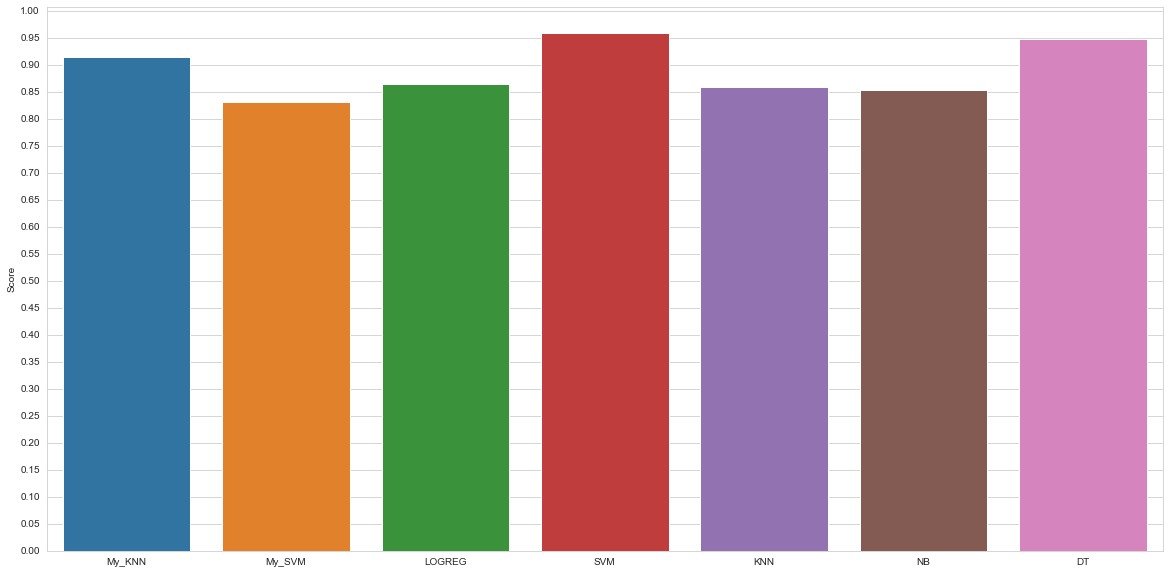

In [60]:
sns.set_style("whitegrid")
plt.figure(figsize=(20, 10))
plt.ylabel("Score")
plt.yticks(np.arange(0, 1.05, 0.05))

sns.barplot(x=list(scores.keys()), y=list(scores.values()))
plt.show()

Построение Confusion Matrix

In [61]:
from sklearn.metrics import confusion_matrix

own_knn_cm = confusion_matrix(y_test, own_knn_y_test_pred)
own_svm_cm = confusion_matrix(y_test, own_svm_y_test_pred)
lib_logreg_cm = confusion_matrix(y_test, lib_logreg_y_test_pred)
lib_knn_cm = confusion_matrix(y_test, lib_knn_y_test_pred)
lib_svm_cm = confusion_matrix(y_test, lib_svm_y_test_pred)
lib_nb_cm = confusion_matrix(y_test, lib_nb_y_test_pred)
lib_dt_cm = confusion_matrix(y_test, lib_dt_y_test_pred)

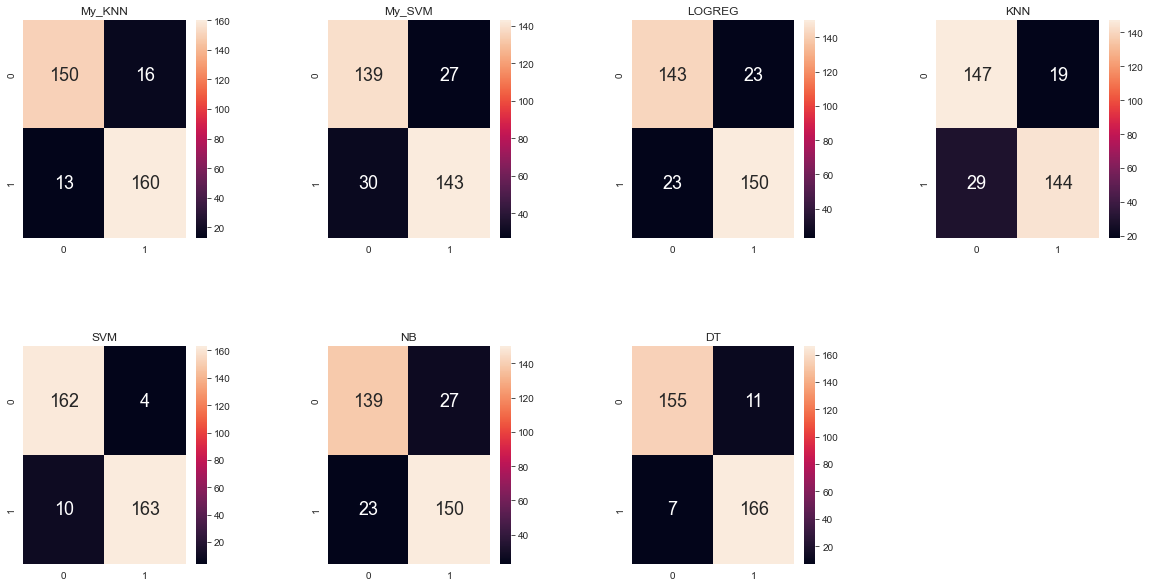

In [63]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.subplot(2, 4, 1)
plt.title("My_KNN")
sns.heatmap(own_knn_cm, annot=True, fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 2)
plt.title("My_SVM")
sns.heatmap(own_svm_cm, annot=True, fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 3)
plt.title("LOGREG")
sns.heatmap(lib_logreg_cm, annot=True, fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 4)
plt.title("KNN")
sns.heatmap(lib_knn_cm, annot=True, fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 5)
plt.title("SVM")
sns.heatmap(lib_svm_cm, annot=True, fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 6)
plt.title("NB")
sns.heatmap(lib_nb_cm, annot=True, fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 7)
plt.title("DT")
sns.heatmap(lib_dt_cm, annot=True, fmt="d", annot_kws={"size": 18})
plt.show()

SVM, DT и My_KNN показали наилучшую точность (> 0.9). При этом лучшая из этих трёх - DT (точность - 0.946).
Собственная реалиация SVM показывает точность предсказания ниже - 0.83, что находится на приблизительно одном уровне с остальными библиотечными реализациями.
Анализ confusion matricies даёт примерно те же выводы. Если мы говорим о том, что хуже получить False Negative, чем False Positive, то тут в лучшую сторону выделяются My_KNN и DT. Плохие результаты у SVM и KNN - мы чаще говорим, что больной пациент здоров, чем наоборот.